# Tensorflow OD
(https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) 

In [1]:
import sys
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import glob
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import cv2
%matplotlib inline



In [2]:
PATH_TO_CKPT ='inference_model/frozen_inference_graph.pb'
NUM_CLASSES = 2
PATH_TO_TEST_IMAGES_DIR = 'data/images'
TEST_IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR+'/*.jpg')
category_index={1:"person",2:"car"}


In [3]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata())[...,:3].reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_dimension(image,
                                              boxes,
                                              classes,
                                              scores,
                                              category_index,
                                              PIL_IMAGE,
                                              instance_masks=None,
                                              keypoints=None,

                                              min_score_thresh=.1,
                                              ):
    im_width, im_height = Image.fromarray(np.uint8(image)).convert('RGB').size 
    #print("Image...")
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_keypoints_map = collections.defaultdict(list)
    
    for i in range(min(100, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
          box = tuple(boxes[i].tolist())
          if instance_masks is not None:
            box_to_instance_masks_map[box] = instance_masks[i]
          if keypoints is not None:
            box_to_keypoints_map[box].extend(keypoints[i])
          else:
             if classes[i] in category_index.keys():
                class_name = category_index[classes[i]]
             else:
                #print(i,classes[i])
                class_name = 'N/A'
            #if not agnostic_mode:
             display_str = '{}: {}%'.format(
                  class_name,
                  int(100*scores[i]))
             box_to_display_str_map[box].append(display_str)
            #else:
              #display_str = 'score: {}%'.format(int(100 * scores[i]))
            
    result = False  
    draw = ImageDraw.Draw(PIL_IMAGE,'RGBA')      
    for box, text in box_to_display_str_map.items():
        ymin, xmin, ymax, xmax = box
        ymin,xmin,ymax,xmax=ymin*im_height,xmin * im_width,ymax*im_height,xmax*im_width
            #im_width, im_height = Image.fromarray(np.uint8(image)).convert('RGB').size 
        #print("xmin:",xmin,"ymin:",ymin,"xmax:",xmax,"ymax:",ymax,text)
        
        draw.rectangle([xmin, ymin, xmax, ymax], fill=(204,255,0,80), outline=(204,255,0))
        w,h=draw.textsize(str(text),font=fnt)

        draw.rectangle(((xmin,ymax+10), (xmin+w, ymax+h+5)), fill="white")
        draw.multiline_text((xmin,ymax+10), str(text), font=fnt,
        fill=(255,0,0,255))

        result=True
  
    return result,PIL_IMAGE

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

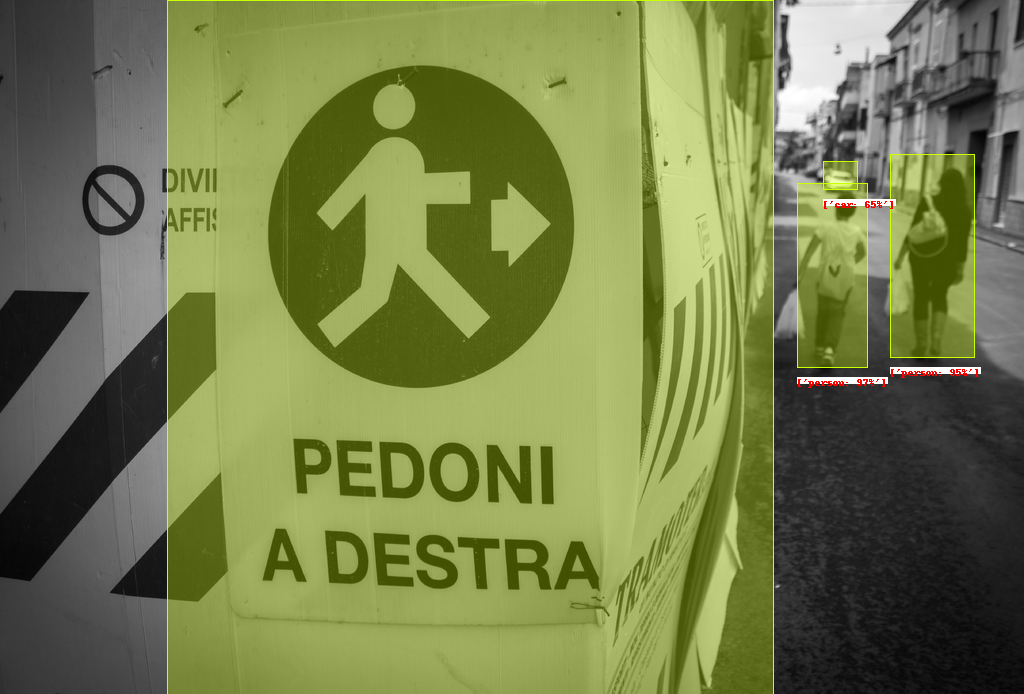

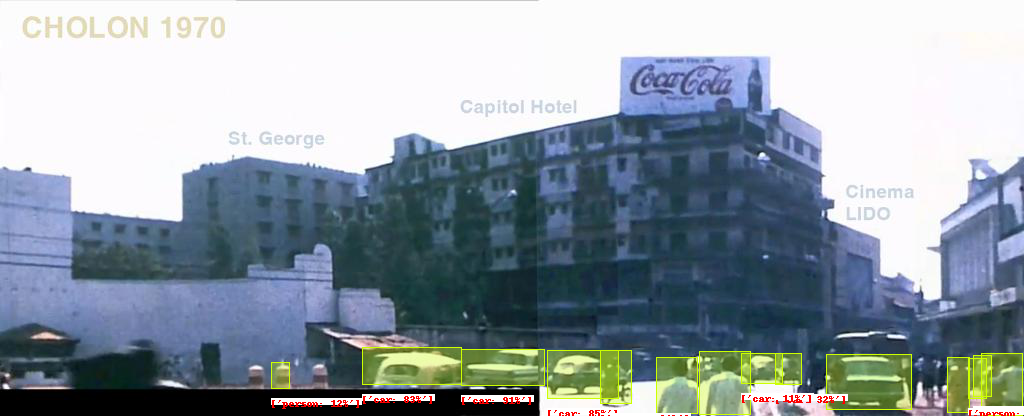

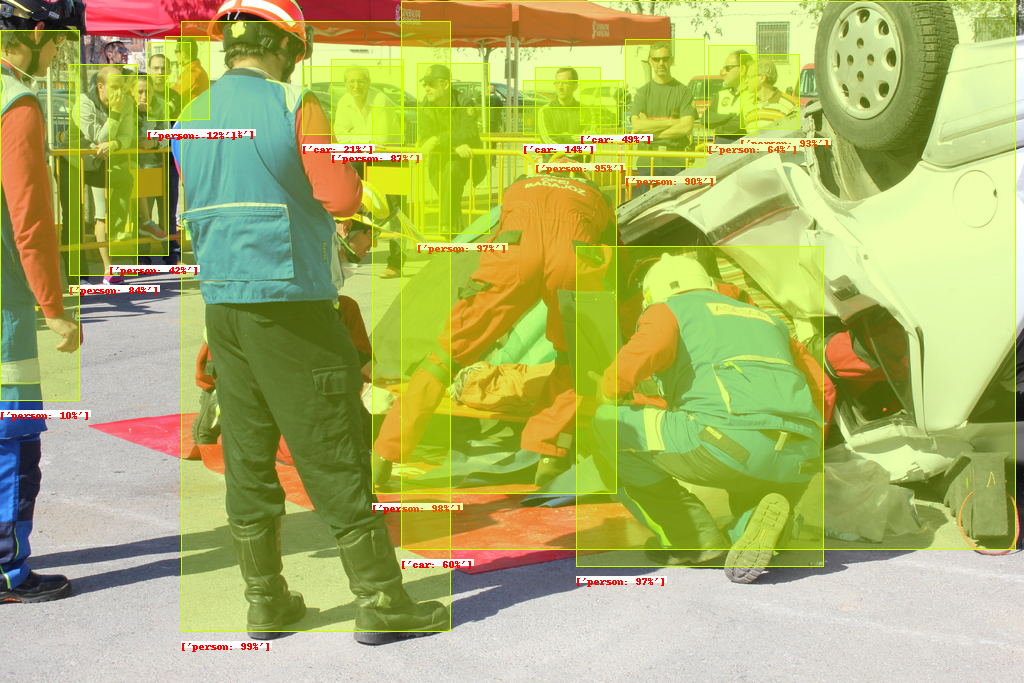

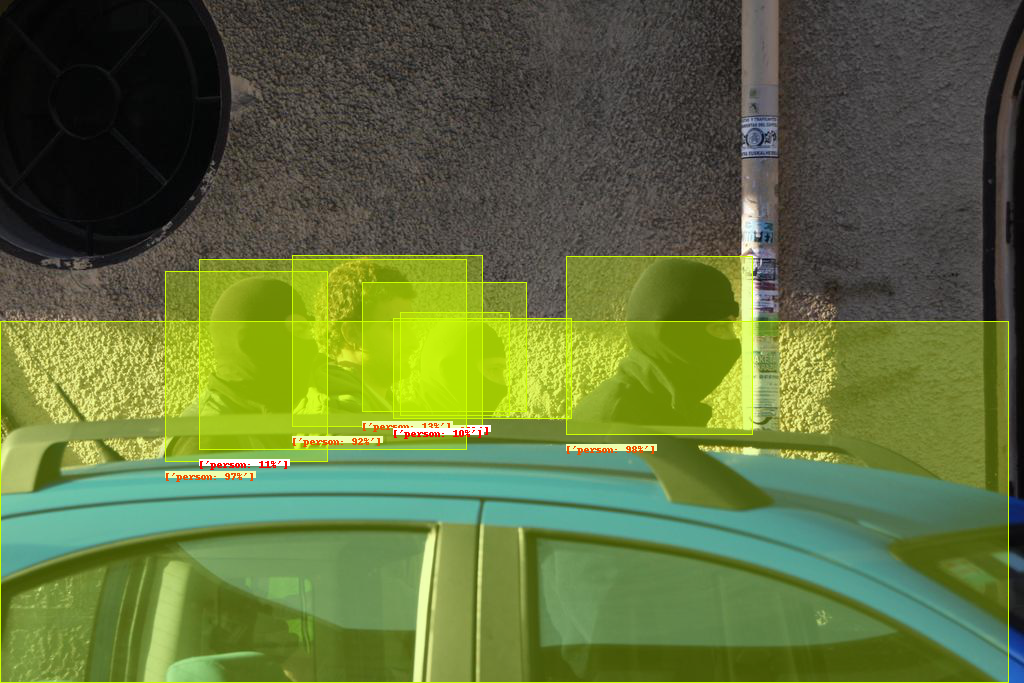

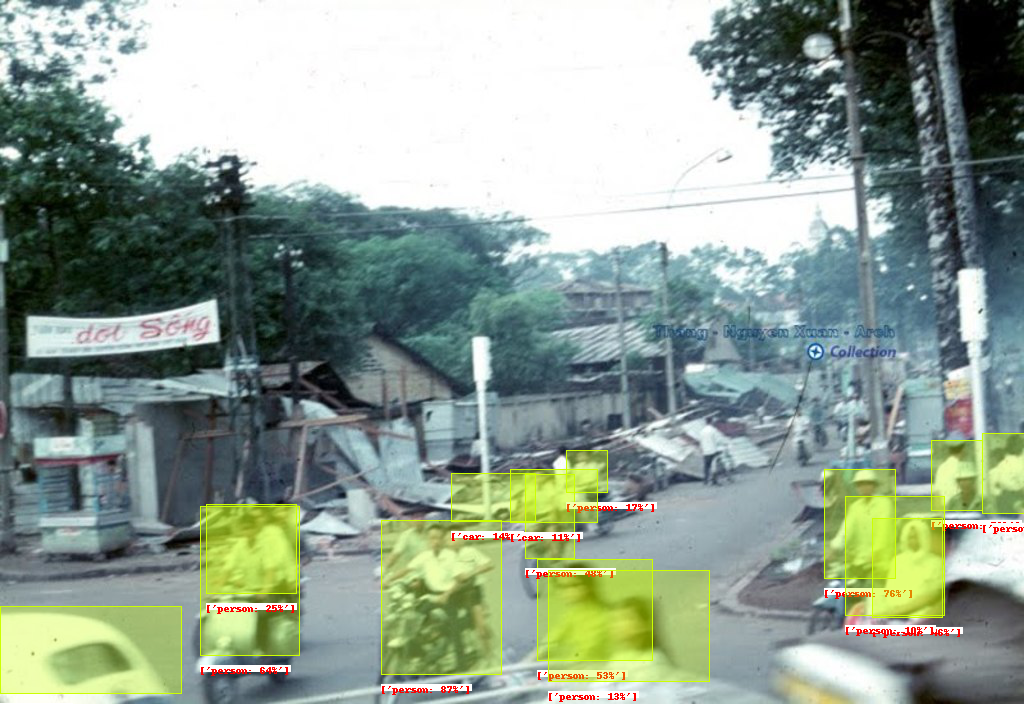

In [5]:
import PIL
from PIL import Image,ImageDraw,ImageFont
from PIL import Image
import collections
from IPython import display
%matplotlib inline
fnt = ImageFont.load_default()
#f, ax = plt.subplots(1, 1, figsize = (20, 20))
with detection_graph.as_default():
    
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    #TEST_IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR+'/*')
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path).convert('RGB')
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
        result,PIL_IMAGE = get_dimension(image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
                                              image)
        #plt.imshow(np.array(PIL_IMAGE))
        display.display(PIL_IMAGE)
        
          
     
      #image_np = np.asarray( image, dtype="uint8" )[...,:3]
    
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
          
        
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          
      # Actual detection.
